In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
#import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
data = pd.concat((pd.read_excel('./Datos_Metagenetica.xlsx', sheet_name='El_cielo', engine='openpyxl'), pd.read_excel('./Datos_Metagenetica.xlsx', sheet_name='Chamela',engine='openpyxl')))
# replace 0 with NaN
data = data.replace(0, np.nan)
#drop columns que no se van a usar 
data = data.drop(['Database','.id', 'similarity', 'phylum_final', 
                  'class_final', 'subfamily_final', 'tribe_final',
                   'subspecies_final', 'BASE', 'OTU'], axis=1)
data

,Sequence,order_final,family_final,genus_final,species_final
0,aataaacaatataagattttggttattgcctccttcattatcactc...,Coleoptera,Mordellidae,NaN,NaN
1,aataaataatataagtttttgacttcttcctccttctttaacctta...,Coleoptera,Carabidae,Glyptolenus,NaN
2,tttaaacaatataagattttgattgttaccaccttcattaactttc...,Coleoptera,Coccinellidae,NaN,NaN
3,tataaacaatataagattctgacttcttccaccttcattaagatta...,Coleoptera,Mordellidae,NaN,NaN
4,aataaataatataagattttgactacttcctccgtcacttaccctt...,Coleoptera,Nitidulidae,NaN,NaN
...,...,...,...,...,...
1778,aataaataatataagtttttgacttttacctcctgcattaacactt...,Diptera,Tachinidae,Ischyrophaga,NaN
1779,aataaataatataagattttgattattaccaccatcaataattata...,Hymenoptera,Ichneumonidae,ichneuMalaiseNA1,NaN
1780,aataaataacataagattttgattactcccaccttctcttttttta...,Hymenoptera,Ichneumonidae,NaN,NaN
1781,aataaataatataagtttctgacttcttcccccttctttaattctt...,Lepidoptera,Erebidae,Arugisa,NaN


# Balance data

In [ ]:
def balance_one_tax_data(df, col_tax_to_balance, tax_to_balance, max_samples) -> pd.DataFrame:
    '''
    df: dataframe with all data to balance
    col_tax_to_balance: column name of the tax to balance
    tax_to_balance: tax to balance
    max_samples: maximum number to save of each tax
    return: balanced dataframe
    '''
    col_index = df.columns.get_loc(col_tax_to_balance)
    if col_index + 1 < len(df.columns):
        next_tax_col = df.columns[col_index + 1]
        vc = df[df[col_tax_to_balance] == tax_to_balance][next_tax_col].value_counts()
        q25 = vc.quantile(0.25)
        selected_values = vc[vc > 4 * q25]
        balanced = pd.DataFrame(columns = df.columns)
        for i in selected_values.index:
            if vc[i] > max_samples:
                balanced = pd.concat((balanced, df[df[next_tax_col] == i].sample(max_samples)))
            else:
                balanced = pd.concat((balanced, df[df[next_tax_col] == i]))
    return balanced

print('Original data')
print(data.value_counts('family_final'))
print('Balanced data')
balance_one_tax_data(data, 'order_final', 'Diptera', 50).value_counts('family_final')

pd.concat((balance_one_tax_data(data, 'order_final', 'Diptera', 50), balance_one_tax_data(data, 'order_final', 'Lepidoptera', 50)))

Original data
family_final
Erebidae           236
Tachinidae         200
Phoridae           162
Ichneumonidae      154
Cecidomyiidae      143
                  ... 
Phacopteronidae      1
Perilampidae         1
Derbidae             1
Disteniidae          1
f__Triozidae         1
Length: 216, dtype: int64
Balanced data


,Sequence,order_final,family_final,genus_final,species_final
775,aataaataatataagattttgattactaccaccagctttaatttta...,Diptera,Tachinidae,Billaea,Malaise4642
348,aataaataatataagattttgattattacccccagctttaaccctt...,Diptera,Tachinidae,Campylocheta,nasellensis
1653,aataaataatataagattttgactccttcctcctgcattaattctt...,Diptera,Tachinidae,NaN,NaN
1301,aataaataatataagtttttgattacttcctcctgctttaatactt...,Diptera,Tachinidae,Pseudochaeta,Pseudochaeta Malaise2497
1430,aataaacaatataagtttttgactccttcctccttctttaacactt...,Diptera,Tachinidae,Austrophorocera,NaN
...,...,...,...,...,...
696,aataaataatataagattttgattacttcccccttcattaaccctt...,Lepidoptera,Pieridae,Ganyra,NaN
701,aataaataatataagattttgaatattacctccttctttaatactt...,Lepidoptera,Pieridae,Ascia,Ascia monuste
723,aataaataatataagtttctgattattacccccttctttaactctc...,Lepidoptera,Pieridae,Pyrisitia,NaN
751,aataaataatataagattttgattacttcccccttctttaacatta...,Lepidoptera,Pieridae,Glutophrissa,NaN


---
# Encoding & Concatenation

In [ ]:
data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())

In [ ]:
def sequence_encoding(sequence):
    mapping = {"A": 0, "C": 1, "G": 2, "T": 3}
    encoded_sequence = [mapping[i] for i in sequence]
    return np.eye(4)[encoded_sequence]

In [ ]:
elem0 = data['Sequence'].iloc[0]
elem1 = data['Sequence'].iloc[1]
elem0

'AATAAACAATATAAGATTTTGGTTATTGCCTCCTTCATTATCACTCCTTTTAATAAGAAGAATCGTAGAAACCGGTGCAGGTACAGGTTGAACAGTGTACCCCCCGCTGTCATCCAATATTGCCCACAGAGGTGCTTCAGTTGATTTAGCTATTTTTAGACTACATTTAGCTGGTATTTCTTCTATTTTAGGAGCAATTAATTTTATTTCTACAATAATTAATATACGACCCGCAGGAATAACCTTTGACCGAATACCCTTATTTGTCTGAGCTATTGCTATTACTGCCGTACTTCTACTATTATCTCTTCCTGTCTTAGCTGGAGCAATTACTATATTATTAACTGATCGAAATTTAAATACTACCTTTTTTGATCCCGCCGGAGGAGGAGATCCAATCTTATATCAACATCTCTTT'

In [ ]:
enc0 = sequence_encoding(elem0)
enc1 = sequence_encoding(elem1)
enc0

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
enc1.shape

(418, 4)

In [ ]:
def side_by_side_sequence(seq1, seq2):
    return np.concatenate((seq1, seq2), axis=1)

In [ ]:
side_by_side_seq = side_by_side_sequence(enc0,enc1)
side_by_side_seq.shape
#type(syde_by_side_seq)

(418, 8)

In [ ]:
side_by_side_seq

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
def deep_sequence(seq1, seq2):
    #s1 = seq1[np.newaxis, :, :]
    #s2 = seq2[np.newaxis, :, :]
    #sequence = np.concatenate((s1, s2), axis=0)
    sequence = np.dstack((seq1, seq2))
    return sequence

In [ ]:
deep_seq = deep_sequence(enc0,enc1)
deep_seq.shape

(418, 4, 2)

In [ ]:
deep_seq

array([[[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]]])

---
# Combinaciones

In [ ]:
datos = {'Col1': ['C', 'A', 'R','M', 'E', 'N'],
        'Col2': ['S','S','M','S','M','M']}

df = pd.DataFrame(datos)
#df

In [ ]:
import itertools

def combination_list(dataframe,column):
    sequences = dataframe[column].tolist()
    combinations = list(itertools.combinations(sequences, 2))
    return combinations

In [ ]:
combinations = combination_list(df,'Col1')
#combinations

In [ ]:
def combination_matrix(df,sequence_column,tax_column):
    combinaciones = []
    for sequence1, sequence2 in combination_list(df,sequence_column):
        z = zip(df[df[sequence_column] == sequence1][tax_column], df[df[sequence_column] == sequence2][tax_column])
        for clase1, clase2 in z:
            combinaciones.append([sequence1, sequence2, clase1, clase2])

    df_combinaciones = pd.DataFrame(combinaciones, columns=['Sequence1', 'Sequence2', 'Tax1', 'Tax2'])
    return df_combinaciones

In [ ]:
nuevo_df = combination_matrix(df,'Col1','Col2')
#nuevo_df

In [ ]:
def tax_comparison(dataframe, tax1, tax2):
    dataframe['Same'] = dataframe[tax1] == dataframe[tax2]
    return dataframe

In [ ]:
input_matrix = tax_comparison(nuevo_df,'Tax1','Tax2')
input_matrix

,Sequence1,Sequence2,Tax1,Tax2,Same
0,C,A,S,S,True
1,C,R,S,M,False
2,C,M,S,S,True
3,C,E,S,M,False
4,C,N,S,M,False
5,A,R,S,M,False
6,A,M,S,S,True
7,A,E,S,M,False
8,A,N,S,M,False
9,R,M,M,S,False


---
# Final Matrix

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def final_matrix(data,concat_type):
    
    #Pasamos a letras mayúsculas las cadenas
    data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())
    #Llamamos a la función para filtrar los datos
    #balanced_data = balance_one_tax_data(data, 'order_final', 'Diptera', 50)
    balanced_data = pd.concat((data[data['order_final'] == 'Diptera'].sample(300), data[data['order_final'] == 'Lepidoptera'].sample(300)))
    #Llamamos a la función para realizar todas las combinaciones
    combinations = combination_matrix(balanced_data,'Sequence','order_final')
    #Llamamos a la función para determinar si los Taxones son iguales
    DNA_matrix = tax_comparison(combinations,'Tax1','Tax2')
    #Pasamos los valores boolean a integer
    DNA_matrix['Same'] = DNA_matrix['Same'].astype(int)
    
    DNA_matrix['Paired_seq'] = ''  # Creamos una columna vacía para almacenar los resultados
    for index, row in DNA_matrix.iterrows():
        sequence1 = row['Sequence1']
        sequence2 = row['Sequence2']
        encoding1 = sequence_encoding(sequence1)
        encoding2 = sequence_encoding(sequence2)
        vectors_padded = pad_sequences([encoding1, encoding2], padding='post')
        paired_sequences = concat_type(vectors_padded[0], vectors_padded[0])
        DNA_matrix.at[index, 'Paired_seq'] = paired_sequences
    return DNA_matrix

In [ ]:
final_matrix = final_matrix(data,side_by_side_sequence)
final_matrix

,Sequence1,Sequence2,Tax1,Tax2,Same,Paired_seq
0,TATAAATAATATAAGATTCTGAATACTACCTCCATCTTTAACTCTT...,AATAAACAACATAAGATTTTGATTATTGCCTCCCTCTTTATCTTTA...,Diptera,Diptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
1,TATAAATAATATAAGATTCTGAATACTACCTCCATCTTTAACTCTT...,ATTAAATAATATAAGATTTTGATTGCTCCCCCCTTCATTAACTTTA...,Diptera,Diptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
2,TATAAATAATATAAGATTCTGAATACTACCTCCATCTTTAACTCTT...,AATAAATAATATAAGCTTTTGATTACTTCCTCCTGCATTAACACTT...,Diptera,Diptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
3,TATAAATAATATAAGATTCTGAATACTACCTCCATCTTTAACTCTT...,AATAAATAATATAAGTTTTTGATTACTTCCTCCTTCTCTTACACTT...,Diptera,Diptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
4,TATAAATAATATAAGATTCTGAATACTACCTCCATCTTTAACTCTT...,AATAAATAATATAAGTTTTTGATTACTTCCTCCTGCTTTAATACTT...,Diptera,Diptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...
179723,TATAAATAATATAAGATTTTGATTATTACCCCCATCTATTACTTTA...,AATAAATAATATAAGTTTTTGACTTCTCCCCCCGTCATTAATTTTA...,Lepidoptera,Lepidoptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
179724,TATAAATAATATAAGATTTTGATTATTACCCCCATCTATTACTTTA...,AATAAATAATATAAGTTTTTGACTTTTGCCTCCTTCCTTAACCTTA...,Lepidoptera,Lepidoptera,1,"[[0, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, ..."
179725,AATAAATAATATAAGTTTTTGATTATTACCCCCCTCTCTTACTTTA...,AATAAATAATATAAGTTTTTGACTTCTCCCCCCGTCATTAATTTTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179726,AATAAATAATATAAGTTTTTGATTATTACCCCCCTCTCTTACTTTA...,AATAAATAATATAAGTTTTTGACTTTTGCCTCCTTCCTTAACCTTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."


In [ ]:
#final_matrix.dtypes

In [ ]:
#final_matrix.to_csv('final_matrix.csv', index=False)

---
# Data preparation for CNN

In [ ]:
from sklearn.model_selection import train_test_split

#final_matrix = pd.read_csv('final_matrix.csv')

# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA = np.array(list(final_matrix.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels = np.array(list(final_matrix.loc[:, 'Same'])) # dim = (31626,1)
#X

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train, DNA_test, labels_train, labels_test = train_test_split(
    DNA, labels, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train.shape)
print("Forma de y_train:", labels_train.shape)

print("Forma de X_test:", DNA_test.shape)
print("Forma de y_test:", labels_test.shape)

Forma de X_train: (143782, 418, 8)
Forma de y_train: (143782,)
Forma de X_test: (35946, 418, 8)
Forma de y_test: (35946,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout
from tensorflow.keras.activations import relu , sigmoid
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, input_shape=(418, 8), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation=relu))
model.add(Dropout(0.5))
model.add(Dense(1, activation=sigmoid))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 414, 64)           2624      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 207, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 203, 200)          64200     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 101, 200)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 101, 200)          0         
                                                                 
 flatten_2 (Flatten)         (None, 20200)            

In [ ]:
# Compile: Define training parameters

epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model.compile(optimizer='sgd' ,loss='binary_crossentropy', metrics=['binary_accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

BATCHES = final_matrix.shape[0] // 64

history = model.fit(DNA_train, labels_train, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 2/50
36/36 - 7s - loss: 0.6552 - binary_accuracy: 0.6271 - val_loss: 0.6180 - val_binary_accuracy: 0.7378 - 7s/epoch - 208ms/step
Epoch 3/50
36/36 - 8s - loss: 0.6256 - binary_accuracy: 0.6644 - val_loss: 0.5863 - val_binary_accuracy: 0.7409 - 8s/epoch - 210ms/step
Epoch 4/50
36/36 - 8s - loss: 0.5999 - binary_accuracy: 0.6858 - val_loss: 0.5614 - val_binary_accuracy: 0.7399 - 8s/epoch - 211ms/step
Epoch 5/50
36/36 - 8s - loss: 0.5783 - binary_accuracy: 0.6992 - val_loss: 0.5427 - val_binary_accuracy: 0.7417 - 8s/epoch - 212ms/step
Epoch 6/50
36/36 - 8s - loss: 0.5628 - binary_accuracy: 0.7057 - val_loss: 0.5291 - val_binary_accuracy: 0.7430 - 8s/epoch - 215ms/step
Epoch 7/50
36/36 - 8s - loss: 0.5514 - binary_accuracy: 0.7116 - val_loss: 0.5196 - val_binary_accuracy: 0.7423 - 8s/epoch - 215ms/step
Epoch 8/50
36/36 - 8s - loss: 0.5426 - binary_accuracy: 0.7139 - val_loss: 0.5124 - val_binary_accuracy: 0.7444 - 8s/epoch - 218ms/step
Epoch 9/50
36/36 - 8s - loss: 0.5352 - binary_ac

In [ ]:
model.save("/content/drive/MyDrive/GEN-DL/S2S_model.h5")

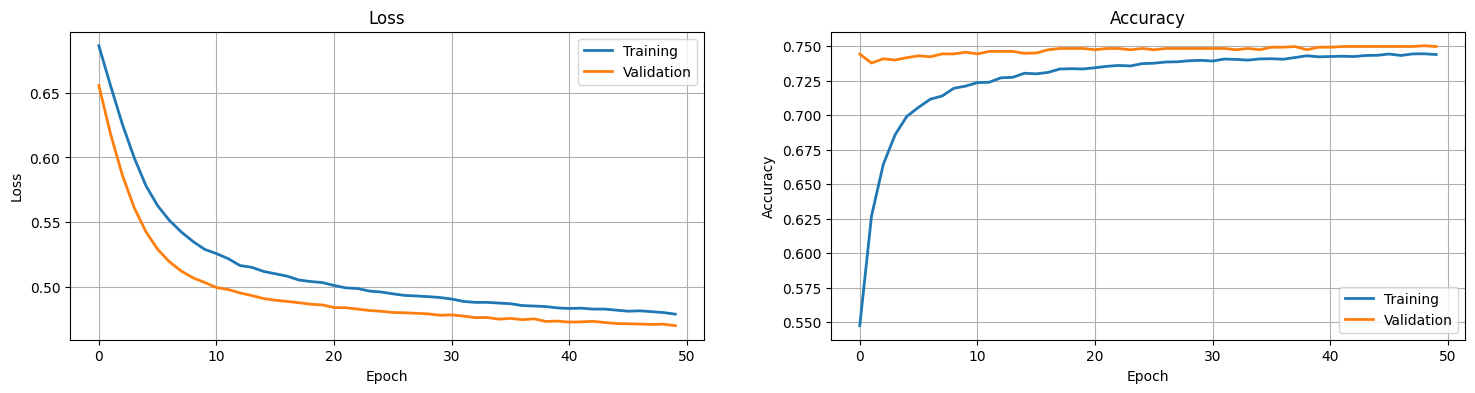

In [ ]:

# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
#DNN = load_model("S2S_model.h5")

y_test_hat = model.predict(x=DNA_test)
print(y_test_hat.shape)


1124/1124 [==============================] - 2s 2ms/step
(35941, 1)


In [ ]:
y_test_hat

array([[0.26772034],
       [0.3159103 ],
       [0.24010718],
       ...,
       [0.9849812 ],
       [0.9826933 ],
       [0.26727155]], dtype=float32)

In [ ]:
Conf_Mat = confusion_matrix(labels_test2, y_test_hat3.round())

ConfusionMatrixDisplay.from_predictions(labels_test2, y_test_hat3.round())
plt.show()

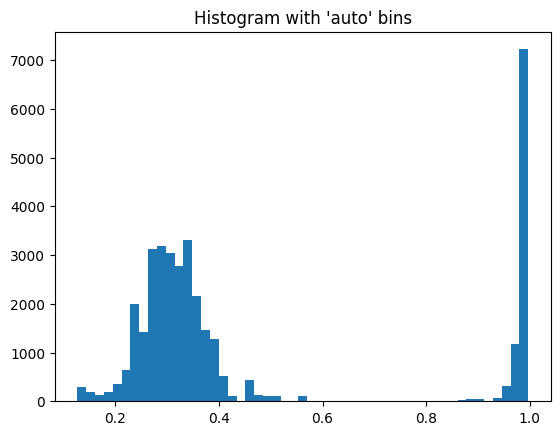

In [ ]:
import matplotlib.pyplot as plt
a = np.hstack((y_test_hat))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()


# Modelo 2

In [ ]:
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=3, activation=relu, input_shape=(418, 8)))
model2.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=64, kernel_size=3, activation=relu))
model2.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(128, activation=relu))
model2.add(Dense(1, activation=sigmoid))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 416, 32)           800       
                                                                 
 conv1d_7 (Conv1D)           (None, 416, 32)           1056      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 208, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 206, 64)           6208      
                                                                 
 conv1d_9 (Conv1D)           (None, 206, 32)           2080      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 103, 32)          0         
 1D)                                                  

In [ ]:
epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_accuracy'])

BATCHES = final_matrix.shape[0] // 64

history2 = model2.fit(DNA_train, labels_train, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
36/36 - 7s - loss: 0.6887 - binary_accuracy: 0.5701 - val_loss: 0.6850 - val_binary_accuracy: 0.6348 - 7s/epoch - 205ms/step
Epoch 2/50
36/36 - 4s - loss: 0.6816 - binary_accuracy: 0.6782 - val_loss: 0.6781 - val_binary_accuracy: 0.7083 - 4s/epoch - 101ms/step
Epoch 3/50
36/36 - 4s - loss: 0.6753 - binary_accuracy: 0.7076 - val_loss: 0.6721 - val_binary_accuracy: 0.7227 - 4s/epoch - 101ms/step
Epoch 4/50
36/36 - 4s - loss: 0.6693 - binary_accuracy: 0.7149 - val_loss: 0.6660 - val_binary_accuracy: 0.7177 - 4s/epoch - 102ms/step
Epoch 5/50
36/36 - 4s - loss: 0.6630 - binary_accuracy: 0.7219 - val_loss: 0.6592 - val_binary_accuracy: 0.7234 - 4s/epoch - 102ms/step
Epoch 6/50
36/36 - 4s - loss: 0.6557 - binary_accuracy: 0.7263 - val_loss: 0.6515 - val_binary_accuracy: 0.7209 - 4s/epoch - 105ms/step
Epoch 7/50
36/36 - 4s - loss: 0.6476 - binary_accuracy: 0.7276 - val_loss: 0.6430 - val_binary_accuracy: 0.7250 - 4s/epoch - 105ms/step
Epoch 8/50
36/36 - 4s - loss: 0.6388 - binary_ac

In [ ]:
model2.save("/content/drive/MyDrive/GEN-DL/S2S_model2.h5")b

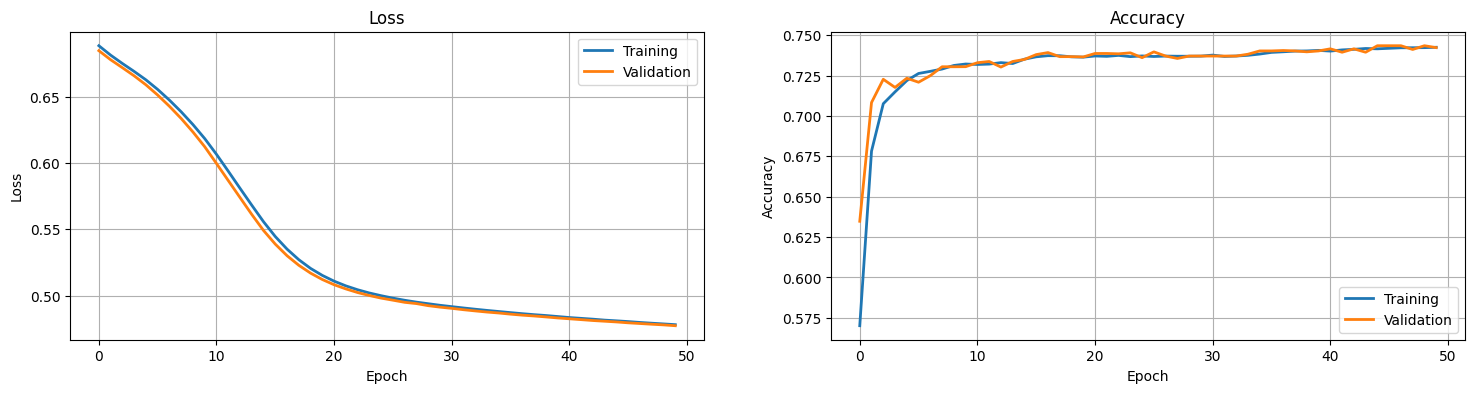

In [ ]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history2.history['loss'], label='Training', linewidth=2)
plt.plot(history2.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history2.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history2.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
y_test_hat = model2.predict(x=DNA_test)
print(y_test_hat.shape)

1124/1124 [==============================] - 2s 2ms/step
(35941, 1)


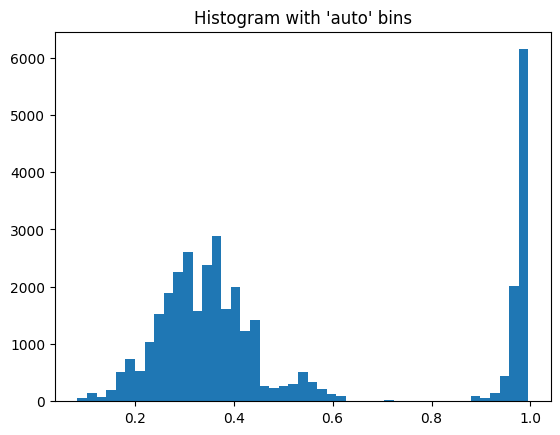

In [ ]:
import matplotlib.pyplot as plt
a = np.hstack((y_test_hat))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

# Modelo 3, data nueva 75%

In [ ]:
def matrix2(data,concat_type,n):
    
    #Pasamos a letras mayúsculas las cadenas
    data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())
    #Llamamos a la función para filtrar los datos
    #balanced_data = balance_one_tax_data(data, 'order_final', 'Diptera', 50)
    balanced_data = pd.concat((data[data['order_final'] == 'Diptera'].sample(300), data[data['order_final'] == 'Lepidoptera'].sample(300)))
    #Llamamos a la función para realizar todas las combinaciones
    combinations = combination_matrix(balanced_data,'Sequence','order_final')
    #Llamamos a la función para determinar si los Taxones son iguales
    DNA_matrix = tax_comparison(combinations,'Tax1','Tax2')
    #Pasamos los valores boolean a integer
    DNA_matrix['Same'] = DNA_matrix['Same'].astype(int)
    
    DNA_matrix['Paired_seq'] = ''  # Creamos una columna vacía para almacenar los resultados
    for index, row in DNA_matrix.iterrows():
        sequence1 = row['Sequence1']
        sequence2 = row['Sequence2']

        parte_k1 = sequence1[:n]
        parte_k2 = sequence2[:n]


        encoding1 = sequence_encoding(parte_k1)
        encoding2 = sequence_encoding(parte_k2)
        vectors_padded = pad_sequences([encoding1, encoding2], padding='post')
        paired_sequences = concat_type(vectors_padded[0], vectors_padded[0])
        DNA_matrix.at[index, 'Paired_seq'] = paired_sequences
    return DNA_matrix

In [ ]:
matrix2 = matrix2(data,side_by_side_sequence,313)
matrix2

,Sequence1,Sequence2,Tax1,Tax2,Same,Paired_seq
0,GTTAAATAATATAAGATTTTGATTACTACCCCCATCTTTAACTTTA...,AATAAATAATATAAGATTTTGACTATTACCCCCCTCTCTTACTCTT...,Diptera,Diptera,1,"[[0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ..."
1,GTTAAATAATATAAGATTTTGATTACTACCCCCATCTTTAACTTTA...,AATAAATAATATAAGTTTTTGACTTTTACCTCCTGCTTTAGTACTT...,Diptera,Diptera,1,"[[0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ..."
2,GTTAAATAATATAAGATTTTGATTACTACCCCCATCTTTAACTTTA...,AATAAATAATTTAAGATTTTGATTATTACCTCCTTCATTATCATTA...,Diptera,Diptera,1,"[[0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ..."
3,GTTAAATAATATAAGATTTTGATTACTACCCCCATCTTTAACTTTA...,CTTAAATAATATAAGATTTTGATTACTCCCCCCTTCATTAACTTTA...,Diptera,Diptera,1,"[[0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ..."
4,GTTAAATAATATAAGATTTTGATTACTACCCCCATCTTTAACTTTA...,AATAAATAATATAAGATTTTGAATACTTCCCCCATCTCTTACTTTA...,Diptera,Diptera,1,"[[0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...
179695,AATAAATAATATAAGATTTTGATTATTACCTCCTTCTTTAATTTTA...,AATAAATAATATAAGTTTCTGACTTCTACCCCCTTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179696,AATAAATAATATAAGATTTTGATTATTACCTCCTTCTTTAATTTTA...,AATAAATAATATAAGATTTTGATTATTACCCCCTTCTTTAACTCTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179697,AATAAATAATATAAGTTTCTGACTTTTACCCCCCTCTCTTACTTTA...,AATAAATAATATAAGTTTCTGACTTCTACCCCCTTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179698,AATAAATAATATAAGTTTCTGACTTTTACCCCCCTCTCTTACTTTA...,AATAAATAATATAAGATTTTGATTATTACCCCCTTCTTTAACTCTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."


In [ ]:
# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA2 = np.array(list(matrix2.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels2 = np.array(list(matrix2.loc[:, 'Same'])) # dim = (31626,1)
#X

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train2, DNA_test2, labels_train2, labels_test2 = train_test_split(
    DNA2, labels2, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train2.shape)
print("Forma de y_train:", labels_train2.shape)

print("Forma de X_test:", DNA_test2.shape)
print("Forma de y_test:", labels_test2.shape)

Forma de X_train: (143760, 313, 8)
Forma de y_train: (143760,)
Forma de X_test: (35940, 313, 8)
Forma de y_test: (35940,)


In [ ]:
model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, activation=relu, input_shape=(313, 8)))
model3.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=64, kernel_size=3, activation=relu))
model3.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(128, activation=relu))
model3.add(Dense(1, activation=sigmoid))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 311, 32)           800       
                                                                 
 conv1d_11 (Conv1D)          (None, 311, 32)           1056      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 155, 32)          0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 153, 64)           6208      
                                                                 
 conv1d_13 (Conv1D)          (None, 153, 32)           2080      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 76, 32)           0         
 1D)                                                  

In [ ]:
epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model3.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_accuracy'])

BATCHES = matrix2.shape[0] // 64

history3 = model3.fit(DNA_train2, labels_train2, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
36/36 - 6s - loss: 0.6919 - binary_accuracy: 0.5627 - val_loss: 0.6853 - val_binary_accuracy: 0.6641 - 6s/epoch - 162ms/step
Epoch 2/50
36/36 - 3s - loss: 0.6822 - binary_accuracy: 0.6586 - val_loss: 0.6790 - val_binary_accuracy: 0.6645 - 3s/epoch - 79ms/step
Epoch 3/50
36/36 - 3s - loss: 0.6762 - binary_accuracy: 0.6774 - val_loss: 0.6730 - val_binary_accuracy: 0.7003 - 3s/epoch - 79ms/step
Epoch 4/50
36/36 - 3s - loss: 0.6699 - binary_accuracy: 0.6965 - val_loss: 0.6664 - val_binary_accuracy: 0.7036 - 3s/epoch - 80ms/step
Epoch 5/50
36/36 - 3s - loss: 0.6631 - binary_accuracy: 0.7012 - val_loss: 0.6594 - val_binary_accuracy: 0.7084 - 3s/epoch - 80ms/step
Epoch 6/50
36/36 - 3s - loss: 0.6559 - binary_accuracy: 0.7113 - val_loss: 0.6517 - val_binary_accuracy: 0.7094 - 3s/epoch - 81ms/step
Epoch 7/50
36/36 - 3s - loss: 0.6479 - binary_accuracy: 0.7136 - val_loss: 0.6434 - val_binary_accuracy: 0.7186 - 3s/epoch - 79ms/step
Epoch 8/50
36/36 - 3s - loss: 0.6393 - binary_accuracy

In [ ]:
model3.save("/content/drive/MyDrive/GEN-DL/S2S_model3.h5")

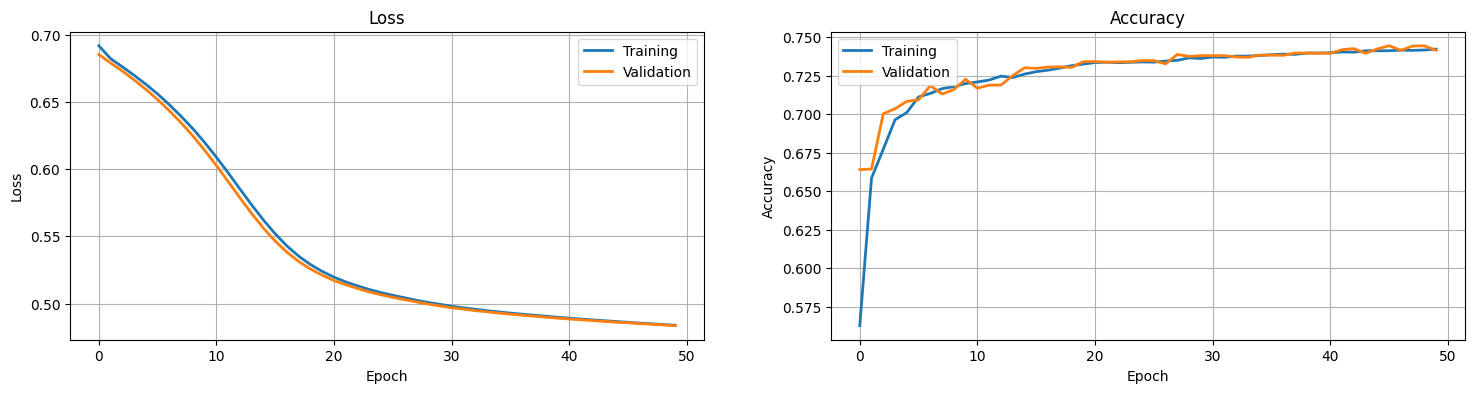

In [ ]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history3.history['loss'], label='Training', linewidth=2)
plt.plot(history3.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history3.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history3.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Compute test loss
test_loss3 = model3.evaluate(x=DNA_test2, y=labels_test2, verbose=False)
test_loss3

[0.48126792907714844, 0.7430439591407776]

In [ ]:
# Predict on test set
y_test_hat3 = model3.predict(x=DNA_test2)
print(y_test_hat3.shape)
print(y_test_hat3.round())

1124/1124 [==============================] - 2s 2ms/step
(35940, 1)
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]


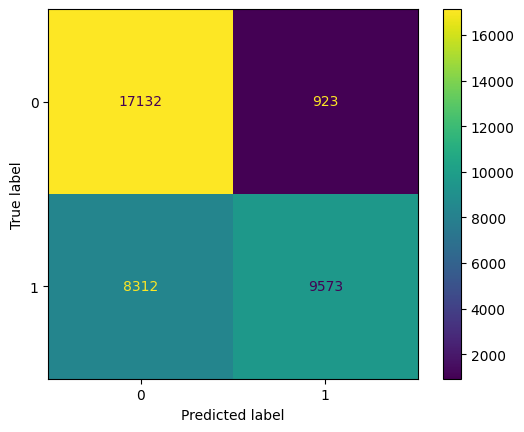

In [ ]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Conf_Mat = confusion_matrix(labels_test2, y_test_hat3.round())

ConfusionMatrixDisplay.from_predictions(labels_test2, y_test_hat3.round())
plt.show()

In [ ]:
def shortener3(data,concat_type,n):
    
    #Pasamos a letras mayúsculas las cadenas
    data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())
    #Llamamos a la función para filtrar los datos
    #balanced_data = balance_one_tax_data(data, 'order_final', 'Diptera', 50)
    balanced_data = pd.concat((data[data['order_final'] == 'Diptera'].sample(300), data[data['order_final'] == 'Lepidoptera'].sample(300)))
    #Llamamos a la función para realizar todas las combinaciones
    combinations = combination_matrix(balanced_data,'Sequence','order_final')
    #Llamamos a la función para determinar si los Taxones son iguales
    DNA_matrix = tax_comparison(combinations,'Tax1','Tax2')
    #Pasamos los valores boolean a integer
    DNA_matrix['Same'] = DNA_matrix['Same'].astype(int)
    
    DNA_matrix['Paired_seq'] = ''  # Creamos una columna vacía para almacenar los resultados
    for index, row in DNA_matrix.iterrows():
        sequence1 = row['Sequence1']
        sequence2 = row['Sequence2']

        parte_k1 = sequence1[:n]
        parte_k2 = sequence2[:n]


        encoding1 = sequence_encoding(parte_k1)
        encoding2 = sequence_encoding(parte_k2)
        vectors_padded = pad_sequences([encoding1, encoding2], padding='post')
        paired_sequences = concat_type(vectors_padded[0], vectors_padded[0])
        DNA_matrix.at[index, 'Paired_seq'] = paired_sequences
    return DNA_matrix

# Modelo 4, data nueva 50%

In [ ]:
matrix3 = shortener3(data,side_by_side_sequence,209)
matrix3

,Sequence1,Sequence2,Tax1,Tax2,Same,Paired_seq
0,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTCTTACACTT...,AATAAATAATATGAGATTTTGACTTCTACCCCCAGCTTTAACATTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
1,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTCTTACACTT...,AATAAATAATATAAGTTTTTGATTATTACCTCCTTCTCTTACTCTT...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
2,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTCTTACACTT...,AATAAATAATATAAGATTTTGATTATTACCTCCTTCTCTTTCATTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
3,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTCTTACACTT...,AATAAATAATATAAGTTTTTGATTGCTCCCCCCAGCTCTAACTTTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
4,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTCTTACACTT...,AATAAATAATATAAGATTTTGACTACTTCCTCCTTCTTTATTATTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...
179710,AATAAATAATATAAGTTTTTGATTATTACCACCTTCTTTAATACTT...,AATAAATAATATAAGATTTTGATTATTACCTCCTTCATTAATATTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179711,AATAAATAATATAAGTTTTTGATTATTACCACCTTCTTTAATACTT...,AATAAATAACATAAGTTTTTGACTCCTTCCCCCTTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179712,CATAAATAACATAAGTTTTTGACTTCTTCCCCCCTCTTTAACTCTT...,AATAAATAATATAAGATTTTGATTATTACCTCCTTCATTAATATTA...,Lepidoptera,Lepidoptera,1,"[[0, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179713,CATAAATAACATAAGTTTTTGACTTCTTCCCCCCTCTTTAACTCTT...,AATAAATAACATAAGTTTTTGACTCCTTCCCCCTTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[0, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 0, ..."


In [ ]:
# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA3 = np.array(list(matrix3.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels3 = np.array(list(matrix3.loc[:, 'Same'])) # dim = (31626,1)
#X

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train3, DNA_test3, labels_train3, labels_test3 = train_test_split(
    DNA3, labels3, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train3.shape)
print("Forma de y_train:", labels_train3.shape)

print("Forma de X_test:", DNA_test3.shape)
print("Forma de y_test:", labels_test3.shape)

Forma de X_train: (143772, 209, 8)
Forma de y_train: (143772,)
Forma de X_test: (35943, 209, 8)
Forma de y_test: (35943,)


In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation=relu, input_shape=(209, 8)))
model4.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Conv1D(filters=64, kernel_size=3, activation=relu))
model4.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(128, activation=relu))
model4.add(Dense(1, activation=sigmoid))

model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 207, 32)           800       
                                                                 
 conv1d_19 (Conv1D)          (None, 207, 32)           1056      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 103, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 101, 64)           6208      
                                                                 
 conv1d_21 (Conv1D)          (None, 101, 32)           2080      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 50, 32)           0         
 g1D)                                                 

In [ ]:
epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model4.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_accuracy'])

BATCHES = matrix3.shape[0] // 64

history4 = model4.fit(DNA_train3, labels_train3, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
36/36 - 5s - loss: 0.6938 - binary_accuracy: 0.5118 - val_loss: 0.6906 - val_binary_accuracy: 0.5531 - 5s/epoch - 133ms/step
Epoch 2/50
36/36 - 2s - loss: 0.6881 - binary_accuracy: 0.6035 - val_loss: 0.6855 - val_binary_accuracy: 0.6542 - 2s/epoch - 54ms/step
Epoch 3/50
36/36 - 2s - loss: 0.6833 - binary_accuracy: 0.6772 - val_loss: 0.6810 - val_binary_accuracy: 0.6783 - 2s/epoch - 54ms/step
Epoch 4/50
36/36 - 2s - loss: 0.6790 - binary_accuracy: 0.6925 - val_loss: 0.6768 - val_binary_accuracy: 0.7072 - 2s/epoch - 54ms/step
Epoch 5/50
36/36 - 2s - loss: 0.6749 - binary_accuracy: 0.7097 - val_loss: 0.6727 - val_binary_accuracy: 0.7102 - 2s/epoch - 54ms/step
Epoch 6/50
36/36 - 2s - loss: 0.6708 - binary_accuracy: 0.7120 - val_loss: 0.6685 - val_binary_accuracy: 0.7128 - 2s/epoch - 54ms/step
Epoch 7/50
36/36 - 2s - loss: 0.6665 - binary_accuracy: 0.7127 - val_loss: 0.6641 - val_binary_accuracy: 0.7185 - 2s/epoch - 54ms/step
Epoch 8/50
36/36 - 2s - loss: 0.6620 - binary_accuracy

In [ ]:
model4.save("/content/drive/MyDrive/GEN-DL/S2S_model4.h5")

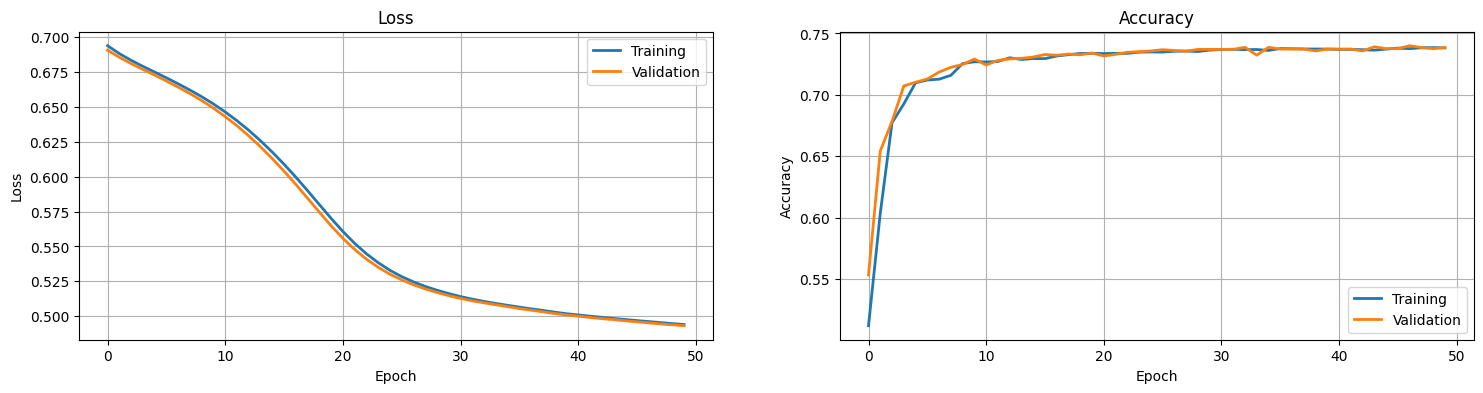

In [ ]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history4.history['loss'], label='Training', linewidth=2)
plt.plot(history4.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history4.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history4.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Compute test loss
test_loss4 = model4.evaluate(x=DNA_test3, y=labels_test3, verbose=False)
test_loss4

[0.4916253983974457, 0.7416464686393738]

In [ ]:
# Predict on test set
y_test_hat3 = model4.predict(x=DNA_test3)
print(y_test_hat3.shape)
print(y_test_hat3.round())

1124/1124 [==============================] - 2s 2ms/step
(35943, 1)
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


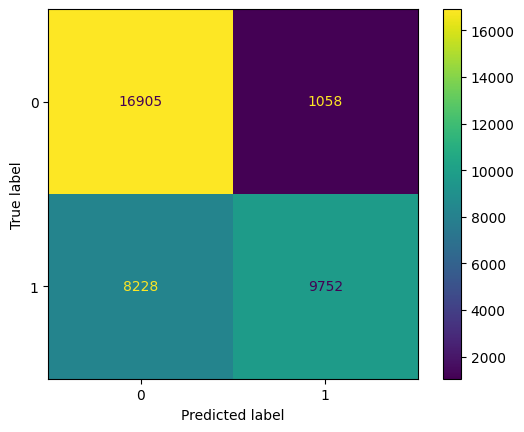

In [ ]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Conf_Mat = confusion_matrix(labels_test3, y_test_hat3.round())

ConfusionMatrixDisplay.from_predictions(labels_test3, y_test_hat3.round())
plt.show()

# Modelo 5, data 25%

In [ ]:
matrix4 = shortener3(data,side_by_side_sequence,104)
matrix4

,Sequence1,Sequence2,Tax1,Tax2,Same,Paired_seq
0,ATTAAATAATTTAAGATTTTGATTATTACCCCCCTCTCTATCTATA...,AATAAATAATATAAGATTCTGATTATTACCTCCTTCTTTATCTTTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
1,ATTAAATAATTTAAGATTTTGATTATTACCCCCCTCTCTATCTATA...,AATGAATAACATAAGTTTTTGACTTCTTCCTCCTGCTTTAACCCTT...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
2,ATTAAATAATTTAAGATTTTGATTATTACCCCCCTCTCTATCTATA...,AATAAATAATATAAGATTTTGAATACTTCCTCCGTCTATTTCTTTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
3,ATTAAATAATTTAAGATTTTGATTATTACCCCCCTCTCTATCTATA...,AATAAATAATATAAGTTTCTGATTACTTCCCCCTGCTCTTTCTCTT...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
4,ATTAAATAATTTAAGATTTTGATTATTACCCCCCTCTCTATCTATA...,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,Diptera,Diptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...
179723,AATAAATAATATAAGTTTTTGATTATTACCTCCTTCTTTAACTCTT...,AATAAATAATATAAGATTTTGATTATTACCCCCCTCATTAACTCTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179724,AATAAATAATATAAGTTTTTGATTATTACCTCCTTCTTTAACTCTT...,AATAAATAATATAAGTTTCTGACTTCTTCCCCCCTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179725,AATAAATAATATAAGATTCTGATTATTACCACCTTCTCTTACTCTT...,AATAAATAATATAAGATTTTGATTATTACCCCCCTCATTAACTCTA...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
179726,AATAAATAATATAAGATTCTGATTATTACCACCTTCTCTTACTCTT...,AATAAATAATATAAGTTTCTGACTTCTTCCCCCCTCTTTAACTCTT...,Lepidoptera,Lepidoptera,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."


In [ ]:
# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA4 = np.array(list(matrix4.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels4 = np.array(list(matrix4.loc[:, 'Same'])) # dim = (31626,1)
#X

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train4, DNA_test4, labels_train4, labels_test4 = train_test_split(
    DNA4, labels4, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train4.shape)
print("Forma de y_train:", labels_train4.shape)

print("Forma de X_test:", DNA_test4.shape)
print("Forma de y_test:", labels_test4.shape)

Forma de X_train: (143782, 104, 8)
Forma de y_train: (143782,)
Forma de X_test: (35946, 104, 8)
Forma de y_test: (35946,)


In [ ]:
model5 = Sequential()
model5.add(Conv1D(filters=32, kernel_size=3, activation=relu, input_shape=(104, 8)))
model5.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(filters=64, kernel_size=3, activation=relu))
model5.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Flatten())
model5.add(Dense(128, activation=relu))
model5.add(Dense(1, activation=sigmoid))

model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 102, 32)           800       
                                                                 
 conv1d_23 (Conv1D)          (None, 102, 32)           1056      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 51, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 49, 64)            6208      
                                                                 
 conv1d_25 (Conv1D)          (None, 49, 32)            2080      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 24, 32)           0         
 g1D)                                                 

In [ ]:
epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model5.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_accuracy'])

BATCHES = matrix4.shape[0] // 64

history5 = model5.fit(DNA_train4, labels_train4, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
36/36 - 5s - loss: 0.6927 - binary_accuracy: 0.5044 - val_loss: 0.6913 - val_binary_accuracy: 0.5408 - 5s/epoch - 131ms/step
Epoch 2/50
36/36 - 1s - loss: 0.6900 - binary_accuracy: 0.5958 - val_loss: 0.6888 - val_binary_accuracy: 0.6418 - 1s/epoch - 29ms/step
Epoch 3/50
36/36 - 1s - loss: 0.6875 - binary_accuracy: 0.6663 - val_loss: 0.6862 - val_binary_accuracy: 0.6821 - 1s/epoch - 28ms/step
Epoch 4/50
36/36 - 1s - loss: 0.6847 - binary_accuracy: 0.6892 - val_loss: 0.6834 - val_binary_accuracy: 0.7039 - 1s/epoch - 28ms/step
Epoch 5/50
36/36 - 1s - loss: 0.6820 - binary_accuracy: 0.7111 - val_loss: 0.6807 - val_binary_accuracy: 0.7101 - 1s/epoch - 28ms/step
Epoch 6/50
36/36 - 1s - loss: 0.6793 - binary_accuracy: 0.7131 - val_loss: 0.6780 - val_binary_accuracy: 0.7138 - 1s/epoch - 29ms/step
Epoch 7/50
36/36 - 1s - loss: 0.6763 - binary_accuracy: 0.7176 - val_loss: 0.6747 - val_binary_accuracy: 0.7155 - 1s/epoch - 28ms/step
Epoch 8/50
36/36 - 1s - loss: 0.6728 - binary_accuracy

In [ ]:
model5.save("/content/drive/MyDrive/GEN-DL/S2S_model5.h5")

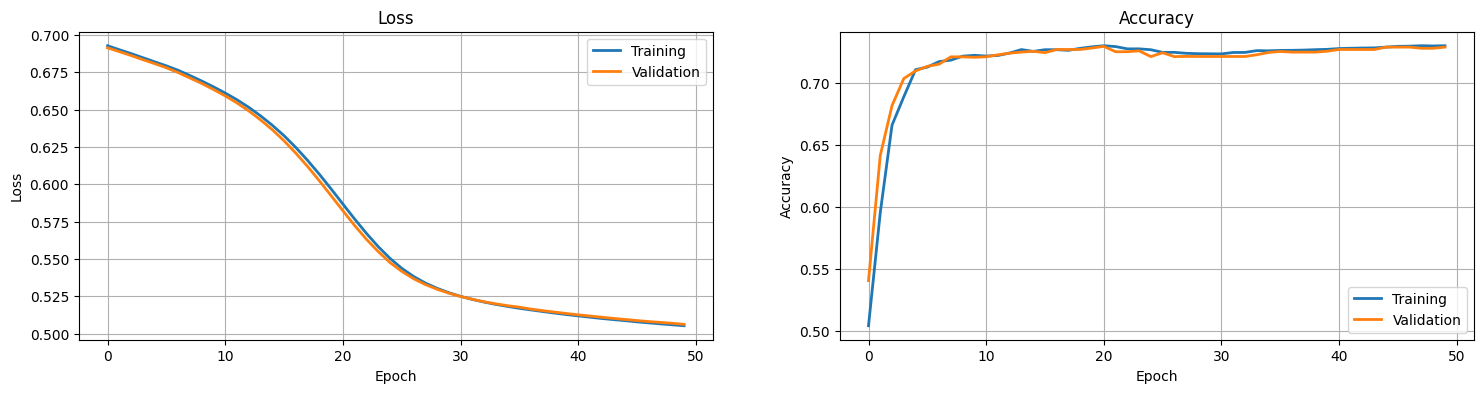

In [ ]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history5.history['loss'], label='Training', linewidth=2)
plt.plot(history5.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history5.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history5.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Compute test loss
test_loss5 = model5.evaluate(x=DNA_test4, y=labels_test4, verbose=False)
test_loss5

[0.5027105808258057, 0.7338786125183105]

In [ ]:
# Predict on test set
y_test_hat4 = model5.predict(x=DNA_test4)
print(y_test_hat4.shape)
print(y_test_hat4.round())

1124/1124 [==============================] - 2s 2ms/step
(35946, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


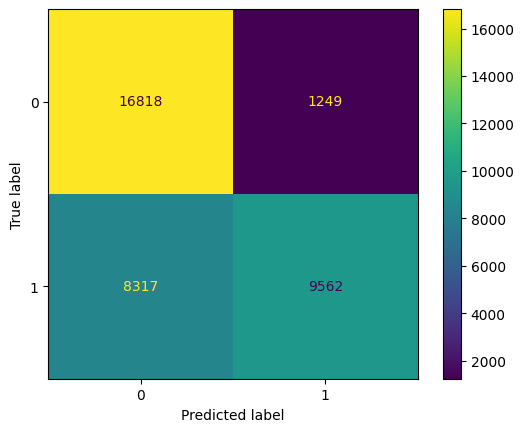

In [ ]:
# Confussion Matrix
Conf_Mat = confusion_matrix(labels_test4, y_test_hat4.round())

ConfusionMatrixDisplay.from_predictions(labels_test4, y_test_hat4.round())
plt.show()

# Modeo last try

In [ ]:
from sklearn.model_selection import train_test_split

#final_matrix = pd.read_csv('final_matrix.csv')

# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA = np.array(list(final_matrix.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels = np.array(list(final_matrix.loc[:, 'Same'])) # dim = (31626,1)
#X

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train, DNA_test, labels_train, labels_test = train_test_split(
    DNA, labels, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train.shape)
print("Forma de y_train:", labels_train.shape)

print("Forma de X_test:", DNA_test.shape)
print("Forma de y_test:", labels_test.shape)

Forma de X_train: (143760, 418, 8)
Forma de y_train: (143760,)
Forma de X_test: (35941, 418, 8)
Forma de y_test: (35941,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate

# Define the siamese network architecture
input_shape = (418, 8)  # Shape of the concatenated input DNA sequences

# Shared convolutional layers
input_sequences = Input(shape=input_shape)

conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')
pool1 = MaxPooling1D(pool_size=2)

conv2 = Conv1D(filters=200, kernel_size=5, activation='relu')
pool2 = MaxPooling1D(pool_size=2)

flatten = Flatten()
dropout = Dropout(0.5)

# Split the input sequences into two parts
seq1, seq2 = tf.split(input_sequences, num_or_size_splits=2, axis=1)

# Process input sequences through shared convolutional layers
encoded_seq1 = flatten(pool2(conv2(pool1(conv1(seq1)))))
encoded_seq2 = flatten(pool2(conv2(pool1(conv1(seq2)))))

# Concatenate the encoded sequences
merged = concatenate([encoded_seq1, encoded_seq2])

# Add fully connected layers
dense1 = Dense(128, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1)

output = Dense(1, activation='sigmoid')(dropout1)

# Create the siamese network model
model = Model(inputs=input_sequences, outputs=output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 418, 8)]     0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 209, 8),     0           ['input_1[0][0]']                
                                 (None, 209, 8)]                                                  
                                                                                                  
 conv1d (Conv1D)                (None, 205, 64)      2624        ['tf.split[0][0]',               
                                                                  'tf.split[0][1]']               
                                                                                              

In [ ]:
# Compile: Define training parameters

epochs = 50
lrate = 0.001
decay = lrate / epochs
model.compile(optimizer='sgd' ,loss='binary_crossentropy', metrics=['binary_accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 50
lrate = 0.001
decay = lrate / epochs
model.compile(optimizer='sgd' ,loss='binary_crossentropy', metrics=['binary_accuracy'])

BATCHES = final_matrix.shape[0] // 64

history = model.fit(DNA_train, labels_train, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30)

Epoch 1/50
36/36 - 22s - loss: 0.6723 - binary_accuracy: 0.6033 - val_loss: 0.6494 - val_binary_accuracy: 0.7443 - 22s/epoch - 600ms/step
Epoch 2/50
36/36 - 8s - loss: 0.6340 - binary_accuracy: 0.6894 - val_loss: 0.6146 - val_binary_accuracy: 0.7352 - 8s/epoch - 225ms/step
Epoch 3/50
36/36 - 8s - loss: 0.6040 - binary_accuracy: 0.7159 - val_loss: 0.5874 - val_binary_accuracy: 0.7416 - 8s/epoch - 227ms/step
Epoch 4/50
36/36 - 8s - loss: 0.5808 - binary_accuracy: 0.7249 - val_loss: 0.5663 - val_binary_accuracy: 0.7447 - 8s/epoch - 228ms/step
Epoch 5/50
36/36 - 8s - loss: 0.5626 - binary_accuracy: 0.7297 - val_loss: 0.5494 - val_binary_accuracy: 0.7407 - 8s/epoch - 230ms/step
Epoch 6/50
36/36 - 8s - loss: 0.5482 - binary_accuracy: 0.7338 - val_loss: 0.5363 - val_binary_accuracy: 0.7428 - 8s/epoch - 233ms/step
Epoch 7/50
36/36 - 8s - loss: 0.5368 - binary_accuracy: 0.7349 - val_loss: 0.5266 - val_binary_accuracy: 0.7412 - 8s/epoch - 236ms/step
Epoch 8/50
36/36 - 9s - loss: 0.5285 - binary_

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the siamese network architecture
input_shape = (418, 8)  # Shape of the concatenated input DNA sequences

# Shared convolutional layers
input_sequences = Input(shape=input_shape)

conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')
pool1 = MaxPooling1D(pool_size=2)

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')
pool1 = MaxPooling1D(pool_size=2)

conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')
pool2 = MaxPooling1D(pool_size=2)

conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')
pool3 = MaxPooling1D(pool_size=2)

flatten = Flatten()
dropout = Dropout(0.5)

# Process input sequences through shared convolutional layers
x = dropout(pool2(conv2(pool1(conv1(input_sequences)))))
x = dropout(pool3(conv3(x)))

# Flatten the output
x = flatten(x)

# Add fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 418, 8)]     0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 209, 8),     0           ['input_1[0][0]']                
                                 (None, 209, 8)]                                                  
                                                                                                  
 conv1d (Conv1D)                (None, 205, 64)      2624        ['tf.split[0][0]',               
                                                                  'tf.split[0][1]']               
                                                                                              

In [ ]:
epochs = 50
lrate = 0.001
decay = lrate / epochs
model.compile(optimizer='sgd' ,loss='binary_crossentropy', metrics=['binary_accuracy'])

BATCHES = final_matrix.shape[0] // 64

history = model.fit(DNA_train, labels_train, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30)

Epoch 1/50
36/36 - 11s - loss: 0.4727 - binary_accuracy: 0.7478 - val_loss: 0.4696 - val_binary_accuracy: 0.7483 - 11s/epoch - 294ms/step
Epoch 2/50
36/36 - 9s - loss: 0.4731 - binary_accuracy: 0.7475 - val_loss: 0.4693 - val_binary_accuracy: 0.7483 - 9s/epoch - 253ms/step
Epoch 3/50
36/36 - 9s - loss: 0.4724 - binary_accuracy: 0.7478 - val_loss: 0.4706 - val_binary_accuracy: 0.7465 - 9s/epoch - 249ms/step
Epoch 4/50
36/36 - 9s - loss: 0.4720 - binary_accuracy: 0.7479 - val_loss: 0.4687 - val_binary_accuracy: 0.7483 - 9s/epoch - 243ms/step
Epoch 5/50
36/36 - 9s - loss: 0.4715 - binary_accuracy: 0.7473 - val_loss: 0.4694 - val_binary_accuracy: 0.7473 - 9s/epoch - 239ms/step
Epoch 6/50
36/36 - 9s - loss: 0.4714 - binary_accuracy: 0.7478 - val_loss: 0.4692 - val_binary_accuracy: 0.7483 - 9s/epoch - 238ms/step
Epoch 7/50
36/36 - 9s - loss: 0.4708 - binary_accuracy: 0.7478 - val_loss: 0.4676 - val_binary_accuracy: 0.7483 - 9s/epoch - 237ms/step
Epoch 8/50
36/36 - 9s - loss: 0.4707 - binary_

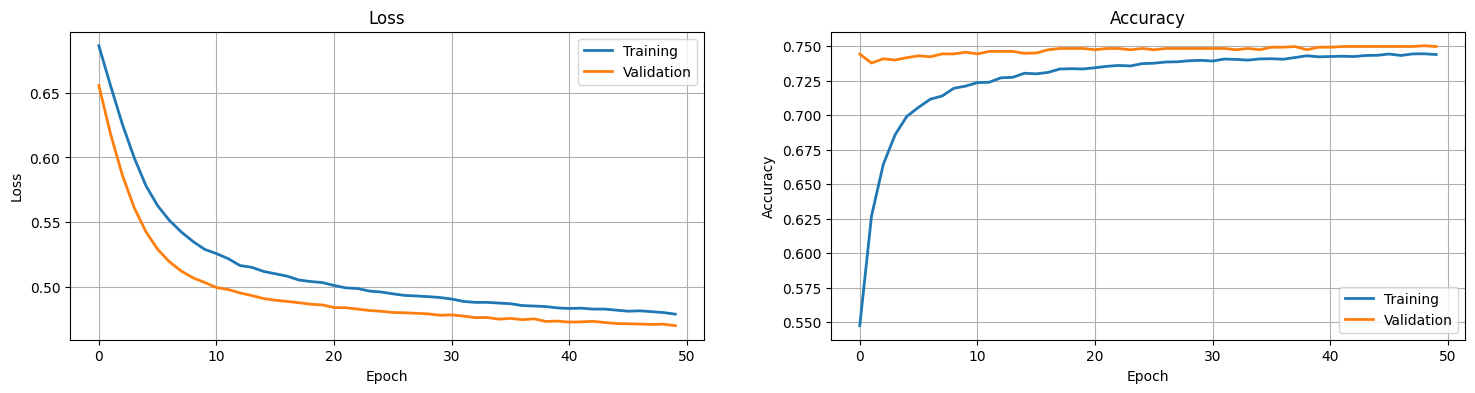

In [ ]:

# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()